In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import corner
import astroquery
import sklearn as skl
import seaborn as sns
import scipy
import statsmodels.api as sm

from skimage import data
from skimage.feature import match_template
from scipy.signal import find_peaks

# Simulate Point Sources

In [2]:
np.random.seed(27)

In [3]:
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')


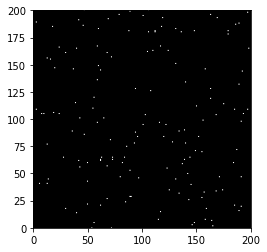

In [4]:
image = np.zeros((500, 500))
simpleRandomPoints = np.array([np.random.rand(1000)*500,np.random.rand(1000)*500]).T
for point in simpleRandomPoints:
    image[int(point[0]), int(point[1])] = 100

plt.imshow(image,vmin=0,vmax=100,cmap='gray', origin='lower')
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()

In [5]:
from scipy.stats import rv_continuous
class flux_distr(rv_continuous):
    "Gaussian distribution"
    def _cdf(self, x):
        return x**(-3/2)
    def _rvs(self, size):
        uniformSamples = np.random.rand(size)
        return uniformSamples**(-2/3)
    def _pdf(self, x):
        return x**(-5/2)
flux_distribution = flux_distr(name='flux_distribution')

In [6]:
simpleRandomPoints
df = pd.DataFrame(simpleRandomPoints.astype(int), columns=['x', 'y'])
df['color'] = np.random.normal(loc=2,scale=0.5,size=len(df))
df['f1'] = flux_distribution._rvs(size=len(df))
df['log_f1'] = np.log(df['f1'])
df['f2'] = df['f1']*df['color']
df['log_f2'] = np.log(df['f2'])
print(df)

       x    y     color        f1    log_f1         f2    log_f2
0    212  489  2.480094  5.986726  1.789545  14.847645  2.697841
1    407   22  2.411564  1.136109  0.127610   2.739800  1.007885
2    367  382  1.507111  1.478547  0.391060   2.228334  0.801254
3    434  259  2.276066  1.443436  0.367026   3.285355  1.189475
4    191   42  2.012668  1.084226  0.080866   2.182187  0.780328
..   ...  ...       ...       ...       ...        ...       ...
995  260  274  1.776567  1.740635  0.554250   3.092355  1.128933
996  384   34  1.895532  1.001109  0.001108   1.897634  0.640608
997  441  426  2.187815  1.005495  0.005480   2.199838  0.788384
998   75   86  1.618431  1.341936  0.294113   2.171831  0.775571
999  195  229  2.011045  1.418303  0.349461   2.852270  1.048115

[1000 rows x 7 columns]


every source is a poisson experiment, so we take some 


for each pixel we have p_ij with some mean mu_ij 
so we do poisson(mu_ij) to get the actual image

we get mu_ij from sum over n sources and do mu_ij from k'th source plus the isotropic source 

mean number of photons for every pixel that comes from the k'th source and we get that from the psf of each source 

plot histogram of log as opposed to the value itself (especially when it comes to flux because of the powerlaw nature)
also as a general rule of thumb really try to minimize whitespace

how are we actually defining the ratio f1 over f2?

GET C FRFOM A LOG NORMAL DISTRIBUTION, NOT JUST A REGULAR DISTRIBUTION

draw f1 from the power law and then use c to get f2

so total flux is f1 but you can plot f2 and c and f1

c physically is the powerlaw index of ln(E) vs ln(f(E))

2500 is a reasonable first amount of sources because it's some integral of dN/dF for f above some f_min, but as we change f_min that changes as well

this number ultimately dictates how crowded your image is

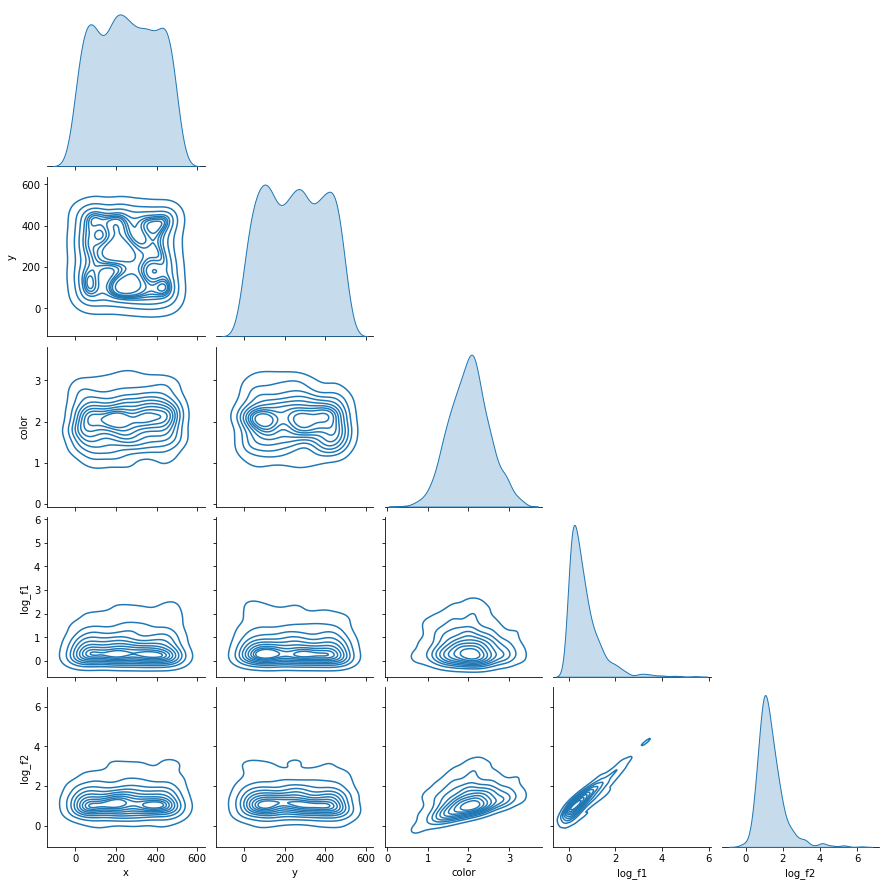

In [7]:

sns.pairplot(data=df, vars=['x', 'y', 'color', 'log_f1','log_f2'],kind='kde',corner=True)
plt.show()

# Simulate Images based on point sources

In [7]:
def gaussian_psf(xcenter, ycenter, size, fwhm=3):
    """
    Generates a 2D Gaussian PSF.

    Args:
        size (int): The size of the PSF array (must be odd).
        fwhm (float): The full width at half maximum of the Gaussian.

    Returns:
        numpy.ndarray: A 2D Gaussian PSF.
    """
    
    x, y = np.indices((size, size))
    #x, y = np.linspace(-size/2,size/2, size), np.linspace(-size/2,size/2, size)
    #xx, yy = np.meshgrid(x, y,indexing='ij')
    
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    gaussian = np.exp(-((x - xcenter)**2 + (y - ycenter)**2) / (2 * sigma**2))
    
    return gaussian 

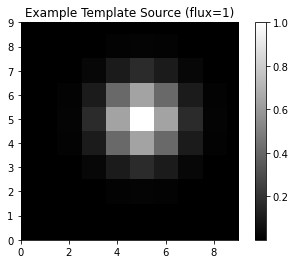

In [8]:
psfExample = gaussian_psf(5,5,10,fwhm=2.5)
plt.imshow(psfExample, cmap='gray', origin='lower')
plt.xlim(0,9)
plt.ylim(0,9)
plt.colorbar()
plt.title("Example Template Source (flux=1)")
plt.show()

how do we decide what to put for the fwhm? also what do I decide to scale the background as?

maybe have it so that the background amount is put as some percentage times the np.sum(fluxes)/number of sources 

BY NEXT WEEK COMPLETE EVERYTHING UP TO MCMC

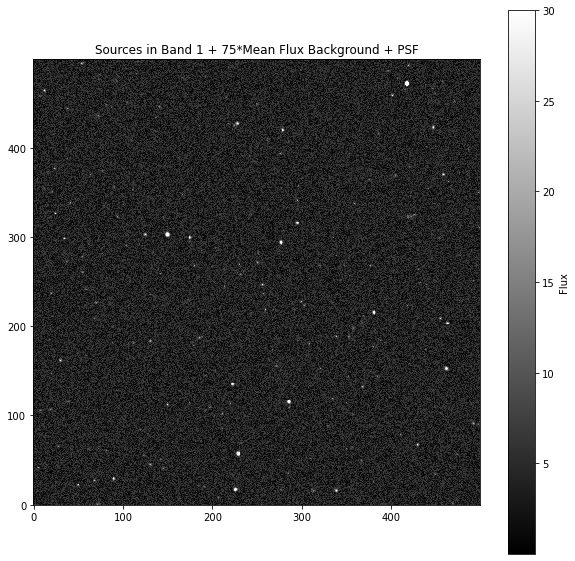

In [9]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f1image = np.zeros((500, 500))


for index, row in df.iterrows():
    f1image[int(row['x']),int(row['y'])] = np.random.poisson(row['f1'], size=1)
    f1image += f1image[int(row['x']),int(row['y'])]*gaussian_psf(int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 75*np.sum(f1image[~np.isnan(image)])/(500*500),size=250000)
randomNoise = randomNoise.reshape((500, 500))

f1image += randomNoise


plt.imshow(f1image, vmax=30, cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Sources in Band 1 + 75*Mean Flux Background + PSF")
plt.show()

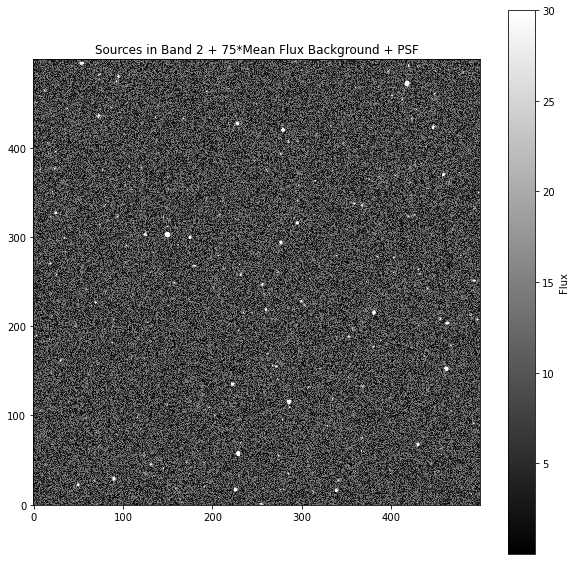

In [10]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f2image = np.zeros((500, 500))


for index, row in df.iterrows():
    f2image[int(row['x']),int(row['y'])] = np.random.poisson(row['f2'], size=1)
    f2image += f2image[int(row['x']),int(row['y'])]*gaussian_psf(int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 75*np.sum(f2image[~np.isnan(image)])/(500*500),size=250000)
randomNoise = randomNoise.reshape((500, 500))

f2image += randomNoise


plt.imshow(f2image, vmax=30, cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Sources in Band 2 + 75*Mean Flux Background + PSF")
plt.show()

image processing residual = data - model

lot of the time this results in some negative I pixels

when get those negatives we take the sinh^-1 which is a good approximation of log for negative and small numbers that log wouldn't be able to actually handle

in the class project in later stages once we start finding sources you will have a model image which represents the underlying data and then we will have to do the data-model and will get those negatives and it will look like white noise

should we have a continuous flux distribution but then from there to get photon counts we somehow take a poisson process

in real application we do want to have decent amount of background

when you do plt.imshow you want to do interpolate= none in order to properly reflect the 

slightly confused about how to show the color and whatnot

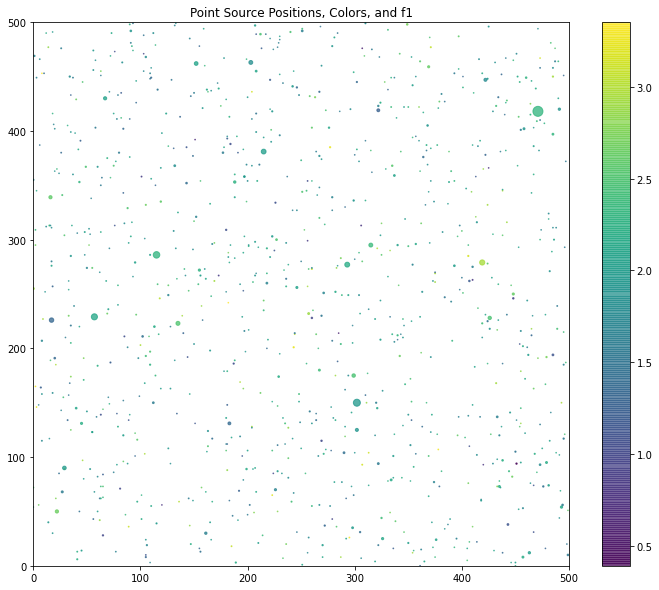

In [12]:
fig,ax = plt.subplots(figsize=(12, 10))
normalizedData = df['f1']/np.max(df['f1'])
plt.scatter(df['x'], df['y'], c=df['color'], s=100*normalizedData, cmap='viridis', alpha=0.75)
plt.title("Point Source Positions, Colors, and f1")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.colorbar()
plt.show()

potentially plot like a scatter plot imshow type combination and then have color be the colorbar but the dot size reflect the flux!!

determine outliers by doing outlier detection as well as template matching if possible 

(where you construct template and put it on your image, multiply on each picture and then sum known as convolution)

# Random notes: ignore below, I will delete it later

use skl for some ML approach to clustering (for the using clustering algorithm to cluster your sources)

# Point Source Finding

find mean across entire window and then run RMS window (what is this pixel's value compared to the mean, knowing the local value of the RMS) if find something greater than 3 sigma, it's a good candidate for a point source

other way to do it is using matched filter (impose particular shape onto the dataset that is the subject of the search)
have templates (sets of apriori knowledge of what a source should look like) and then run this through the image getting some value and some weight where you ask "does this look like the template?" 

if shifting by full pixels, you might miss some because need subpixel shifts if a source is in btwn two pixels 
you need some neat in the middle point between some crazy small ridiculous amount like 0.01 and 1 full pixel


from this you get a list of candidates and then need to fit and whatnot 


using WLS --> establish linear regression problem and consider weighted least squares where cov matrix is pretty simple where the diagonal is the var for each individual pixel 


MCMC part does require you to fit an MCMC sampler, specifically using the metropolis hastings equation 

don't have to do the variations of results stuff for all i don't think, but def do it for when you change the gaussian PSF to one iwth an additional poower-law tail where you have an extra bright source and its tail is covariant with some of the other sources 
(basically other sources have gaussian, but after some scale the extra bright one is a power law)

model covariance matrix will therefore be very non-diagonal 

see if you can get a signal out of that still 

also we can do not just the population with dN/dF powerlaw index=-5/2, but can also have another population where you change the powerlaw index of our dN/dF & see what the implications are down the pipeline

also we can see the implications that come from only including sources brighter than some struct minimum count cut-off--> note how do we choose different values of the cut off and the effect you have from making it super low or super high

## Outlier Detection

### 50x50 Sections

In [21]:
candidatePositions = []
flux1CandidatePositions = []

for i in range(0,400,50):
    for j in range(0,400,50):
        imageSection = f1image[min(0,np.abs(i-50)):max(500,i+50),min(0,np.abs(j-50)):max(500,j+50)]
        mean = np.mean(imageSection[~np.isnan(imageSection)])
        std = np.std(imageSection[~np.isnan(imageSection)])
        threshold = mean + 3*std
        row, column = np.where(imageSection > threshold)
        for k in range(0,len(row)):
            flux1CandidatePositions.append(np.array([row[k]+min(0,np.abs(i-50)),column[k]+min(0,np.abs(j-50))]))
        
        imageSection = f2image[min(0,np.abs(i-50)):max(500,i+50),min(0,np.abs(j-50)):max(500,j+50)]
        mean = np.mean(imageSection[~np.isnan(imageSection)])
        std = np.std(imageSection[~np.isnan(imageSection)])
        threshold = mean + 3*std
        row, column = np.where(imageSection > threshold)
        prevCandidates =set(tuple(arr) for arr in flux1CandidatePositions)
        currentCandidates = set(tuple(arr) for arr in candidatePositions)
        for k in range(0,len(row)):
            if(tuple([row[k]+min(0,np.abs(i-50)),column[k]+min(0,np.abs(j-50))]) in prevCandidates):
                candidatePositions.append(np.array([row[k]+min(0,np.abs(i-50)),column[k]+min(0,np.abs(j-50))]))
print(candidatePositions)

[array([ 15, 313]), array([ 15, 338]), array([ 15, 339]), array([ 16, 225]), array([ 16, 226]), array([ 16, 227]), array([ 16, 338]), array([ 16, 339]), array([ 16, 340]), array([ 17, 225]), array([ 17, 226]), array([ 17, 227]), array([ 17, 338]), array([ 17, 339]), array([ 18, 225]), array([ 18, 226]), array([ 20, 191]), array([21, 50]), array([22, 49]), array([22, 50]), array([27, 68]), array([28, 89]), array([28, 90]), array([28, 91]), array([29, 89]), array([29, 90]), array([29, 91]), array([30, 89]), array([30, 90]), array([ 35, 285]), array([ 40, 145]), array([ 45, 131]), array([ 55, 228]), array([ 55, 229]), array([ 55, 230]), array([ 56, 228]), array([ 56, 229]), array([ 56, 230]), array([ 56, 231]), array([ 57, 227]), array([ 57, 228]), array([ 57, 229]), array([ 57, 230]), array([ 57, 231]), array([ 58, 227]), array([ 58, 228]), array([ 58, 229]), array([ 58, 230]), array([ 59, 228]), array([ 59, 229]), array([ 66, 430]), array([ 66, 431]), array([ 67, 429]), array([ 67, 430]

In [22]:
trueCandidates = []
candidatePositions = np.array(candidatePositions)
for candidate in candidatePositions:
    #closePoints = []
    closePoints = candidatePositions[np.sqrt((candidate[0]-candidatePositions[:,0])**2+(candidate[1]-candidatePositions[:,1])**2)<=2]
    if len(closePoints)==0:
        trueCandidates.append(candidate)
        continue
    avgX = int(np.median(closePoints[:,0]))
    avgY = int(np.median(closePoints[:,1]))
    if np.array([avgX,avgY]) in np.array(trueCandidates):
        continue
    trueCandidates.append(np.array([avgX,avgY]))
    #print(np.array([avgX,avgY]))
print(len(trueCandidates))

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


81


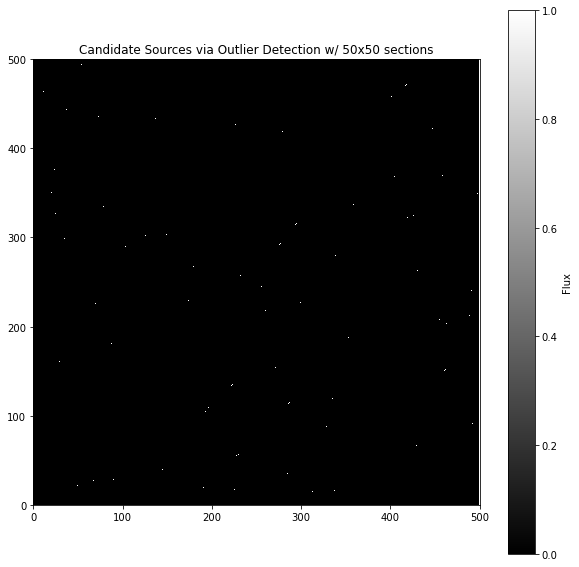

In [17]:
candidatePositions = trueCandidates

fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    candidateImage[int(candidate[0]),int(candidate[1])] = 1
plt.imshow(candidateImage, cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ 50x50 sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

### 100x100 Sections

In [18]:
candidatePositions = []
flux1CandidatePositions = []

#temporarily did the 5 sigma instead to try and decrease number of suggested sources so that hopefully my code runs fine
for i in range(0,400,100):
    for j in range(0,400,100):
        imageSection = f1image[min(0,np.abs(i-100)):max(500,i+100),min(0,np.abs(j-100)):max(500,j+100)]
        mean = np.mean(imageSection[~np.isnan(imageSection)])
        std = np.std(imageSection[~np.isnan(imageSection)])
        threshold = mean + 5*std
        row, column = np.where(imageSection > threshold)
        for k in range(0,len(row)):
            flux1CandidatePositions.append(np.array([row[k]+min(0,np.abs(i-100)),column[k]+min(0,np.abs(j-100))]))
        
        imageSection = f2image[min(0,np.abs(i-100)):max(500,i+100),min(0,np.abs(j-100)):max(500,j+100)]
        mean = np.mean(imageSection[~np.isnan(imageSection)])
        std = np.std(imageSection[~np.isnan(imageSection)])
        threshold = mean + 5*std
        row, column = np.where(imageSection > threshold)
        prevCandidates =set(tuple(arr) for arr in flux1CandidatePositions)
        currentCandidates = set(tuple(arr) for arr in candidatePositions)
        for k in range(0,len(row)):
            if(tuple([row[k]+min(0,np.abs(i-100)),column[k]+min(0,np.abs(j-100))]) in prevCandidates):
                candidatePositions.append(np.array([row[k]+min(0,np.abs(i-100)),column[k]+min(0,np.abs(j-100))]))
print(candidatePositions)

[array([ 15, 339]), array([ 16, 226]), array([ 16, 338]), array([ 16, 339]), array([ 16, 340]), array([ 17, 225]), array([ 17, 226]), array([ 17, 227]), array([ 18, 225]), array([ 18, 226]), array([22, 50]), array([28, 90]), array([29, 89]), array([29, 90]), array([29, 91]), array([30, 90]), array([ 45, 131]), array([ 55, 229]), array([ 56, 228]), array([ 56, 229]), array([ 56, 230]), array([ 57, 227]), array([ 57, 228]), array([ 57, 229]), array([ 57, 230]), array([ 57, 231]), array([ 58, 228]), array([ 58, 229]), array([ 58, 230]), array([ 67, 430]), array([114, 285]), array([114, 286]), array([114, 287]), array([115, 284]), array([115, 285]), array([115, 286]), array([115, 287]), array([115, 288]), array([116, 285]), array([116, 286]), array([116, 287]), array([117, 286]), array([119, 335]), array([134, 222]), array([134, 223]), array([134, 224]), array([135, 222]), array([135, 223]), array([135, 224]), array([136, 222]), array([136, 223]), array([136, 224]), array([151, 462]), arra

In [19]:
trueCandidates = []
candidatePositions = np.array(candidatePositions)
for candidate in candidatePositions:
    #closePoints = []
    closePoints = candidatePositions[np.sqrt((candidate[0]-candidatePositions[:,0])**2+(candidate[1]-candidatePositions[:,1])**2)<=2]
    if len(closePoints)==0:
        trueCandidates.append(candidate)
        continue
    avgX = int(np.median(closePoints[:,0]))
    avgY = int(np.median(closePoints[:,1]))
    if np.array([avgX,avgY]) in np.array(trueCandidates):
        continue
    trueCandidates.append(np.array([avgX,avgY]))
    #print(np.array([avgX,avgY]))
print(len(trueCandidates))

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


48


(3136, 2)
(48, 2)


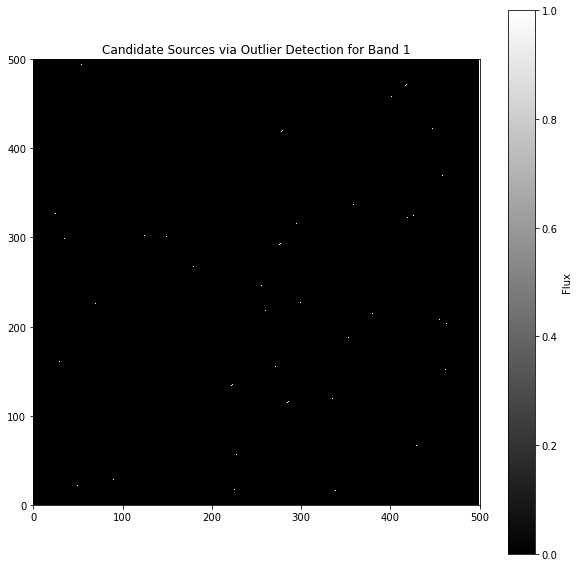

In [20]:
candidatePositions = trueCandidates
print(np.array(flux1CandidatePositions).shape)
print(np.array(candidatePositions).shape)

fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    candidateImage[int(candidate[0]),int(candidate[1])] = 1
plt.imshow(candidateImage, cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection for Band 1")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

## Template Matching

### Band 1

19503


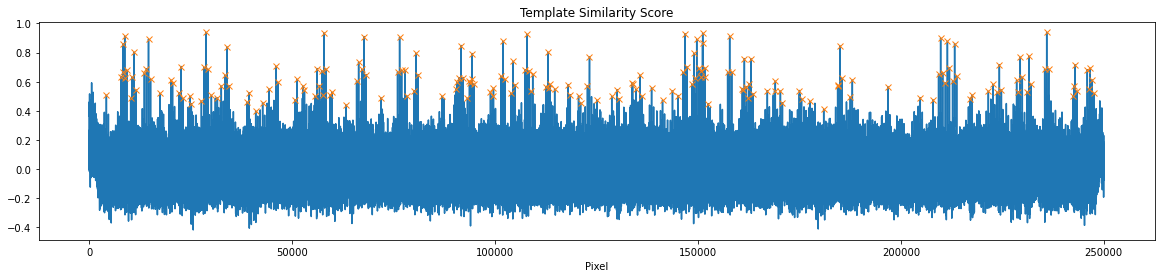

In [24]:
image = f1image
candidatePositions = []

for exFlux in range(1, 100):
    exPointSource = exFlux*gaussian_psf(5,5,10,fwhm=2.5)


    result = match_template(image, exPointSource,pad_input=True)

    flattenedResult = result.flatten()
    peaks = find_peaks(flattenedResult,prominence=0.75,width=2.5)[0]

    for p in peaks:
        ij = np.unravel_index(p, result.shape)
        x, y = ij[::-1]
        candidatePositions.append(np.array([x,y]))



print(len(candidatePositions))
fig,ax = plt.subplots(figsize=(20, 4))
#plt.plot(fullSizeResult.flatten(order='F'), label='Result')
plt.plot(flattenedResult, label='Flattened Result')
plt.plot(peaks, flattenedResult[peaks], "x")
plt.title("Template Similarity Score")
plt.xlabel("Pixel")
plt.show()


In [25]:
trueCandidates = []
candidatePositions = np.array(candidatePositions)
for candidate in candidatePositions:
    #closePoints = []
    closePoints = candidatePositions[np.sqrt((candidate[0]-candidatePositions[:,0])**2+(candidate[1]-candidatePositions[:,1])**2)<=2]
    if len(closePoints)==0:
        trueCandidates.append(candidate)
        continue
    avgX = np.round(np.median(closePoints[:,0]))
    avgY = np.round(np.median(closePoints[:,1]))
    if np.array([avgX,avgY]) in np.array(trueCandidates):
        continue
    trueCandidates.append(np.array([avgX,avgY]))
    #print(np.array([avgX,avgY]))
print(len(trueCandidates))

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


96


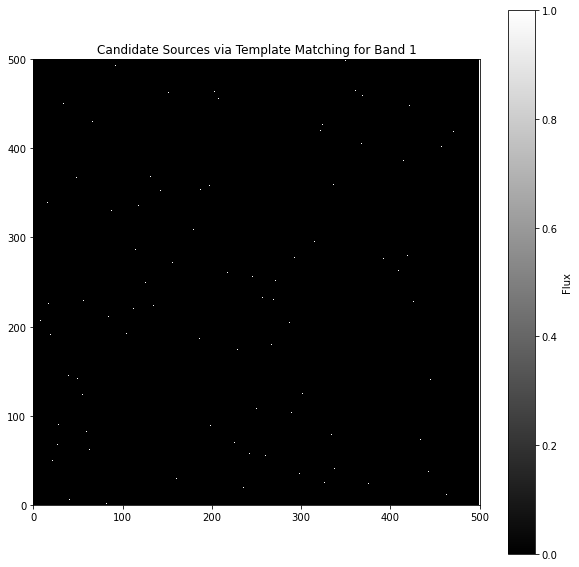

In [26]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(trueCandidates)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    candidateImage[int(candidate[0]),int(candidate[1])] = 1
plt.imshow(candidateImage, cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Template Matching for Band 1")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

### Band 1 + Band 2

34152


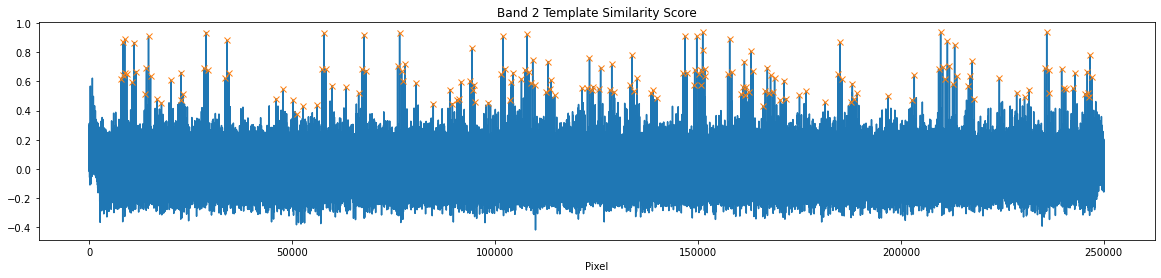

In [28]:
image = f2image
#basically have the candidate positions be the remaining candidates from band 1 and this time get the candidates from band 2
candidatePositions = trueCandidates
#f2CandidatePositions = []

for exFlux in range(1, 100):
    exPointSource = exFlux*gaussian_psf(5,5,10,fwhm=2.5)


    result = match_template(image, exPointSource,pad_input=True)

    flattenedResult = result.flatten()
    peaks = find_peaks(flattenedResult,prominence=0.75,width=2.5)[0]

    for p in peaks:
        ij = np.unravel_index(p, result.shape)
        x, y = ij[::-1]
        candidatePositions.append(np.array([x,y]))



print(len(candidatePositions))
fig,ax = plt.subplots(figsize=(20, 4))
plt.plot(flattenedResult, label='Flattened Result')
plt.plot(peaks, flattenedResult[peaks], "x")
plt.title("Band 2 Template Similarity Score")
plt.xlabel("Pixel")
plt.show()


In [29]:
trueCandidates = []
candidatePositions = np.array(candidatePositions)
for candidate in candidatePositions:
    closePoints = candidatePositions[np.sqrt((candidate[0]-candidatePositions[:,0])**2+(candidate[1]-candidatePositions[:,1])**2)<=2]
    if len(closePoints)==0:
        trueCandidates.append(candidate)
        continue
    avgX = np.round(np.median(closePoints[:,0]))
    avgY = np.round(np.median(closePoints[:,1]))
    if np.array([avgX,avgY]) in np.array(trueCandidates):
        continue
    trueCandidates.append(np.array([avgX,avgY]))
print(len(trueCandidates))

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


119


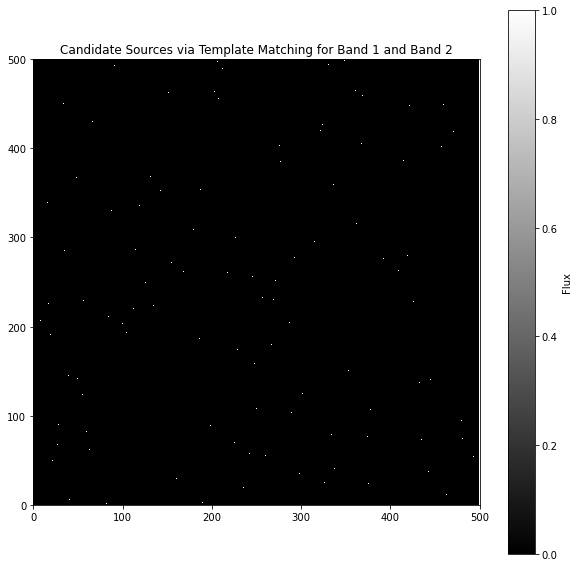

In [30]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(trueCandidates)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    candidateImage[int(candidate[0]),int(candidate[1])] = 1
plt.imshow(candidateImage, cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Template Matching for Band 1 and Band 2")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

# WLS

is there a way to include the color in the WLS setup? there has to be I just have to sit down and do it somehow

In [31]:
designMatrix = np.zeros((500*500,len(trueCandidates)+1))

for j in range(0,len(trueCandidates)):
    psfImage = gaussian_psf(int(trueCandidates[j][0]), int(trueCandidates[j][1]), size=500, fwhm=2.5)
    psfImage = psfImage.reshape(500*500, order='F')
    designMatrix[:250000,j] = psfImage

#include a constant term for the background flux
designMatrix[:,len(trueCandidates)] = 1
imageMatrix = f1image.reshape(500*500, order='F')

In [32]:
#we take the weights to be the inverse of the variance of the flux measurement for each pixel 
#because we model it as a poisson process we can say that the variance is equal to the flux (which is taken to be the mean hit count for a given obs. period)
mod_wls = sm.WLS(imageMatrix, designMatrix, weights=1.0/imageMatrix)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.493
Date:                Wed, 09 Apr 2025   Prob (F-statistic):          2.61e-118
Time:                        11:29:05   Log-Likelihood:            -6.6272e+05
No. Observations:              250000   AIC:                         1.326e+06
Df Residuals:                  249880   BIC:                         1.327e+06
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.9413      1.679      2.943      0.0

In [33]:
trueCandidates = np.array(trueCandidates)
finalSources = np.array([trueCandidates[:,0],trueCandidates[:,1]]).T
finalSources.shape

proposedSources = pd.DataFrame(finalSources, columns=['x', 'y'])
proposedSources['flux'] = res_wls.params[:-1]
backgroundFlux = res_wls.params[-1]
print(proposedSources)

         x      y      flux
0    207.0    8.0  4.941259
1    339.0   16.0  3.240798
2    226.0   17.0  5.885876
3    191.0   20.0  4.363487
4     50.0   22.0  1.162013
..     ...    ...       ...
114  449.0  460.0  5.791756
115   93.0  473.0  2.367751
116   95.0  480.0  4.093072
117   74.0  481.0  4.725164
118   54.0  493.0  1.206999

[119 rows x 3 columns]


if do it the other way with flux as independent var then we can have the model be based on the flux of the nearby points maybe?

first find candidates of point sources (from our outlier detection or template matching). --> right now i am doing outlier detection but need to do template matching as well

use WLS where in the regression problem you have y = x* beta + residual 
X is the design matrix, beta is the parameters, and residual is errors

y is a column of the pixels of our candidate sources (n_pix times 1)

this is equal to our design matrix times our beta where beta is a (N by 1 number of fluxes)--> or you could include the background as well in which case it's n+2 times 1

assume ony degree of freedom per band is the flux 

every free parameter in beta is the flux value of one template and each template is the expected emission you would expect to get from a source


imagine you have your pixel j somewhere in y... for pixel j you're taking the template value of a given source at j, multiplying it by the amplitude of the j'th source, and do this summing over all possible sources

each row in x is different 


beta is going to basically be a row of your fluxes that you solve for 

x = for a given column what would the impact of the point source be on that given pixel. 
every column is one of your candidate sources and then too the last are your background (which is usually treated as isotropic)

you are summing up all of the contributions of your given model on each pixel within the full image. 

the columns are largely 0 besides for some small region around the pixel

completely unrelated note

lomb scargle basically is a fourier transform to see the power spectral density graph but for the case where you have gaps in the data 

for clustering you should do it from flux vs color

# MCMC 
for this section we want to use MCMC in order to sample from the posterior (which basically tells how likely the parameters we choose are true given the data)


prior for the position is uniform

prior for the flux is some powerlaw with alpha = -1 

prior for the color is uniform (but not worrying about the color rn)

what should I set the sigma for the proposal to be?
also what should I assume the priors to be? I feel like the uniform prior for the positions are reasonable but would the expected prior of alpha=5/2 be reasonable or would it be biased because it's from me knowing what to expect? also what should i set the prior for the background to be???--> USE OUR KNOWN DISTRIBUTIONS

also can we just assume and set the marginal P(data) to be 1 (basically can we ignore it?)?

how do I handle the likelihood of multiple pixels??? like do I just multiply the likelihood of each pixel?

In [ ]:
#i just put 0 as the initial values right now but it really shouldn't start like that
trueImage = f1image
#currentThetaState right now is the shape of beta so that's nFluxes +1 (for the background)
#we want the currentThetaState to include the positions of the sources as well, should I do it so it's shape (3,nFluxes+1) where the columns are x, y, and flux?

#need to set my initial current theta by pulling from my priors????
currentThetaStatePixels = np.zeros((3,res_wls.params.shape-1))
currentThetaStateImage = np.zeros((500, 500))
currentThetaStateBackground = 0
currentPosterior = np.nan

#kernel probability is just going to be uniform between 0 and 1
stateCount = 0
states = []

totalCurrentLikelihood = 1
totalCurrentXPrior = 1
totalCurrentYPrior = 1
totalCurrentFluxPrior = 1

while(stateCount<10):
    proposedThetaStatePixels = np.zeros((3,res_wls.params.shape-1))
    proposedThetaStateImage = np.zeros((500, 500))
    proposedThetaStateBackground = 0
    #only actually save every tenth state
    if(stateCount%10==0) and (not np.isnan(currentPosterior)):
        states.append([currentThetaStatePixels, currentThetaStateBackground])

    #i'm assuming a background which is sampled using a uniform distribution between 0 and background. 
    #for the very first time we take this upper limit to be some random number btwn 0 and 10
    if(np.isnan(currentPosterior)):
        currentThetaStateBackground = np.random.uniform(0,10)
        randomCurrentNoise = np.random.uniform(0, currentThetaStateBackground,size=250000)
        randomCurrentNoise = randomCurrentNoise.reshape((500, 500))
        currentThetaStateImage += randomCurrentNoise
    proposedThetaStateBackground = np.random.normal(loc=currentThetaStateBackground,scale=0.5)
    randomProposedNoise = np.random.uniform(0, proposedThetaStateBackground,size=250000)
    randomProposedNoise = randomProposedNoise.reshape((500, 500))
    proposedThetaStateImage += randomProposedNoise
    
    
    totalProposedLikelihood = 1
    totalProposedXPrior = 1
    totalProposedYPrior = 1
    totalProposedFluxPrior = 1
    
    for i in range(0,currentThetaStatePixels.shape[1]):
        for j in range(0,3):
            #propose a new theta
            proposedThetaStatePixels[j][i] = np.random.normal(loc=currentThetaStatePixels[j][i],scale=0.5)
        if(np.isnan(currentPosterior)):
            totalCurrentXPrior*=1/500
            totalCurrentYPrior*=1/500
            totalCurrentFluxPrior*=flux_distribution._pdf(currentThetaStatePixels[2][i])
            currentThetaStateImage += currentThetaStatePixels[2][i]*gaussian_psf(int(currentThetaStatePixels[0][i]), int(currentThetaStatePixels[1][i]), size=500, fwhm=2.5)
        
        totalProposedXPrior*=1/500
        totalProposedYPrior*=1/500
        totalProposedFluxPrior*=flux_distribution._pdf(proposedThetaStatePixels[2][i])
        proposedThetaStateImage += proposedThetaStatePixels[2][i]*gaussian_psf(int(proposedThetaStatePixels[0][i]), int(proposedThetaStatePixels[1][i]), size=500, fwhm=2.5)
        
    for x in range(0,500):
        for y in range(0,500):
            knownPixelFlux = trueImage[x,y]

            #if a given sources has a true flux 1 within a pixel we can model the observed flux w/o background
            #note that the knownPixelFlux isn't necesarrily an int but i'm taking an int stance of things 
            if(np.isnan(currentPosterior)):
                currentLikelihood = (1/5)*scipy.stats.poisson.pmf(int(knownPixelFlux), int(currentThetaStateImage[x,y]))
                for i in range(1,currentThetaStateBackground):
                    currentLikelihood += (1/5)*scipy.stats.poisson.pmf(int(knownPixelFlux)-i, int(currentThetaStateImage[x,y]))
                totalCurrentLikelihood *= currentLikelihood

            proposedLikelihood = (1/5)*scipy.stats.poisson.pmf(int(knownPixelFlux), int(proposedThetaStateImage[x,y]))
            for i in range(1,proposedThetaStateBackground):
                proposedLikelihood += (1/5)*scipy.stats.poisson.pmf(int(knownPixelFlux)-i, int(proposedThetaStateImage[x,y]))
            totalProposedLikelihood *= proposedLikelihood


    #assuming that the marginal probability is just 1 (aka negligible)
    if(np.isnan(currentPosterior)):
        currentPosterior = totalCurrentFluxPrior*totalCurrentXPrior*totalCurrentYPrior*totalCurrentLikelihood
    proposedPosterior = totalProposedFluxPrior*totalProposedXPrior*totalProposedYPrior*totalProposedLikelihood
    


    acceptanceProb = np.random.uniform(0,1)
    transitionProb = np.min([1,proposedPosterior/currentPosterior])
    #have to check if this is correct
    if(transitionProb>=acceptanceProb):
        currentThetaStatePixels = proposedThetaStatePixels
        currentThetaStateBackground = proposedThetaStateBackground
        currentPosterior = proposedPosterior
        currentThetaStateImage = proposedThetaStateImage

    stateCount += 1

P(expected pixel flux==known pixel flux) = for all i: P(sample from assumed background distribution = i)*P(sample from flux = known pixel flux-i)


if known pixel flux = 

once I'm done with my stretch goal we could try to enforce a knowingly wrong prior, however for now it's fine to assume we have the correct priors!